# Markovian model of swiss railways

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import ipywidgets as widgets

In [2]:
from datetime import datetime, timedelta
from ipywidgets import interact, interact_manual
from tqdm.notebook import trange, tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

[See the medium article 'SBB trains delay'](https://medium.com/@christopher.hogendijk/sbb-trains-delay-4b1e23f3bd15)

In [4]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [5]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [6]:
# Collect features
features = []

In [7]:
# One feature per day
for day in tqdm(data['BETRIEBSTAG'].unique()):
    feature = data[data['BETRIEBSTAG'] == day]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

### Overview

In [8]:
features[0].describe(include=['O'])

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
count,86739,86739,86739,86739,86739,86739,86739,86739,86739,86739,79135,78467,86739,79129,78462,86739,86739
unique,1,7952,4,1,7948,82,17,2,2,963,1527,48251,3,1525,47735,3,2
top,01.09.2019,85:65:11867:002,SBB,Zug,11878,R,S,False,False,Zürich HB,01.09.2019 17:24,01.09.2019 11:54:39,REAL,01.09.2019 17:39,01.09.2019 13:35:37,REAL,False
freq,86739,37,56205,86739,37,8604,61175,86411,86519,1865,96,7,75663,98,9,75897,86738


In [9]:
# Example of one route
features[0].loc[(features[0].FAHRT_BEZEICHNER == '85:65:11869:002')].head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
74787,01.09.2019,85:65:11869:002,THURBO,Zug,11869,S8,S,False,False,8506302.0,St. Gallen,NaN,NaN,PROGNOSE,01.09.2019 18:49,01.09.2019 18:49:25,REAL,False
74788,01.09.2019,85:65:11869:002,THURBO,Zug,11869,S8,S,False,False,8506303.0,St. Gallen St. Fiden,01.09.2019 18:52,01.09.2019 18:51:59,REAL,01.09.2019 18:52,01.09.2019 18:52:49,REAL,False
74789,01.09.2019,85:65:11869:002,THURBO,Zug,11869,S8,S,False,False,8506393.0,Wittenbach,01.09.2019 18:57,01.09.2019 18:56:25,REAL,01.09.2019 18:57,01.09.2019 18:57:27,REAL,False
74790,01.09.2019,85:65:11869:002,THURBO,Zug,11869,S8,S,False,False,8506394.0,Roggwil-Berg,01.09.2019 18:59,01.09.2019 18:59:39,REAL,01.09.2019 18:59,01.09.2019 19:00:14,REAL,False
74791,01.09.2019,85:65:11869:002,THURBO,Zug,11869,S8,S,False,False,8506395.0,Häggenschwil-Winden,01.09.2019 19:02,01.09.2019 19:03:01,REAL,01.09.2019 19:02,01.09.2019 19:03:25,REAL,False


### Count

In [10]:
# Plot it!
@interact
def plot(day=(0, len(features) - 1)):
    features[day]['HALTESTELLEN_NAME'].value_counts(1).plot.bar(figsize=(50, 6), fontsize=5)

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

### Load stations dataset (didok)

In [11]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")
didok.head()

,LAENDERCODE,NUMMER,PRUEFZIFFER,BPUIC,SLOID,BEZEICHNUNG_OFFIZIELL,BEZEICHNUNG_LANG,ABKUERZUNG,STATUS,IS_BETRIEBSPUNKT,...,GO_BEZEICHNUNG_FR,GO_BEZEICHNUNG_IT,GO_BEZEICHNUNG_EN,BAV_BEMERKUNG,ERSTELLT_AM,GEAENDERT_AM,GUELTIG_VON,GUELTIG_BIS,MIN_GUELTIG_VON,MAX_GUELTIG_BIS
0,85,4048,5,8504048,ch:1:sloid:4048,"Villariaz, Moulin Rouge",NaN,NaN,3,1,...,Service d'automobiles TPF,Service d'automobiles TPF,Service d'automobiles TPF,NaN,2018-07-03 09:50:24,2018-07-18 12:34:15,2018-06-28,2018-07-02,2018-06-28,2099-12-31
1,85,4049,3,8504049,ch:1:sloid:4049,"Villarepos, F. de Plan",NaN,NaN,3,1,...,Service d'automobiles TPF,Service d'automobiles TPF,Service d'automobiles TPF,NaN,2018-07-03 09:53:48,2018-08-22 20:12:57,2018-06-28,2018-07-02,2018-06-28,2099-12-31
2,85,19024,9,8519024,ch:1:sloid:19024,Basel SBB RB West,NaN,BRBW,3,1,...,Chemins de fer fédéraux suisses CFF,Ferrovie federali svizzere FFS,Schweizerische Bundesbahnen SBB,NaN,2018-07-30 14:19:37,2018-07-30 14:19:37,2018-07-19,2018-07-29,2013-07-25,2099-12-31
3,85,19025,6,8519025,ch:1:sloid:19025,Basel SBB RB Ost,NaN,BRBO,3,1,...,Chemins de fer fédéraux suisses CFF,Ferrovie federali svizzere FFS,Schweizerische Bundesbahnen SBB,NaN,2018-07-30 14:20:46,2018-07-30 14:20:46,2018-07-19,2018-07-29,2013-07-25,2099-12-31
4,85,57043,2,8557043,ch:1:sloid:57043,"Ennetbaden, Rütenen-Felmen",NaN,NaN,3,1,...,CarPostal SA,AutoDaPosta SA,PostBus Ltd,NaN,2017-11-09 11:53:05,2019-03-28 08:03:08,2017-05-23,2017-06-02,2017-05-23,2099-12-31


In [12]:
# Coordinates in gtfs
gtfs = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'E_WGS84', 'N_WGS84']].drop_duplicates()
gtfs = gtfs[np.isfinite(gtfs['E_WGS84'])]
gtfs = gtfs.reset_index()
gtfs = gtfs.drop(columns=['index'])
gtfs

,BPUIC,BEZEICHNUNG_OFFIZIELL,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",-14.764508,35.330601
2,8519024,Basel SBB RB West,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",0.379039,47.265918
...,...,...,...,...
41952,1149001,"Aulendorf, Bahnhof",13.402789,52.518201
41953,1100104,"Maulburg, Berghöfe",13.445183,52.501212
41954,1108014,Ludwigshafen Heinr.-Pesch-Haus,13.517518,52.387161
41955,1162685,"Bad Schussenried, Aldi-Kreisel",13.588883,52.453507


### Locations in project as BPUIC

In [13]:
# These are the specific stations of the project
locations = data.copy(deep=True)
locations = locations[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations

,HALTESTELLEN_NAME,BPUIC
0,Basel Bad Bf,8500090
1,Basel SBB,8500010
2,Schaffhausen,8503424
3,Zürich HB,8503000
4,Interlaken Ost,8507492
...,...,...
1015,Bure-Casernes,8500131
1016,Basel SBB GB,8500040
1017,S-chanf Marathon,8517481
1018,Mels,8509412


### Georeferenced locations by BPUIC

In [14]:
geopos = []
for i, location in enumerate(locations.values):
    lon = gtfs.loc[gtfs['BPUIC']==location[1]].values[0][2]
    lat = gtfs.loc[gtfs['BPUIC']==location[1]].values[0][3]
    loc = [lon, lat]
    geopos.append(loc)

In [15]:
locations['geopos'] = geopos
locations.head()

,HALTESTELLEN_NAME,BPUIC,geopos
0,Basel Bad Bf,8500090,"[7.60728379, 47.56814685]"
1,Basel SBB,8500010,"[7.58955093, 47.54740464]"
2,Schaffhausen,8503424,"[8.632719999999999, 47.69827999]"
3,Zürich HB,8503000,"[8.540189999999999, 47.378170000000004]"
4,Interlaken Ost,8507492,"[7.869, 46.69050001]"


## Model construction

In [ ]:
# Collect starting vectors
initials = []
# Collect transition matrices
matrices = []
# Collect states
states = []

for feature in tqdm(features):

    # Dictionary of stations
    dic = {'station': np.unique(feature['HALTESTELLEN_NAME'])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    # Initialize a n*1 initial start vector
    t = (n)
    Initial = pd.DataFrame(np.zeros(t))
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))

    for route in tqdm(feature.FAHRT_BEZEICHNER.unique(),
                      desc=feature['BETRIEBSTAG'].unique()[0]):

        temp = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        # Sort routes by scheduled departure
        temp = temp.sort_values(by='ABFAHRTSZEIT', ascending=True, na_position='last')

        # Calculate scheduled running times
        temp['RUNNING'] = (
            pd.to_datetime(temp['ANKUNFTSZEIT'].shift(-1), format="%d.%m.%Y %H:%M") -
            pd.to_datetime(temp['ABFAHRTSZEIT'], format="%d.%m.%Y %H:%M")
        ).dt.total_seconds().fillna(0).astype(int)
        
        # Calculate scheduled dwell times
        temp['DWELL'] = (
            pd.to_datetime(temp['ABFAHRTSZEIT'], format="%d.%m.%Y %H:%M") -
            pd.to_datetime(temp['ANKUNFTSZEIT'], format="%d.%m.%Y %H:%M")
        ).dt.total_seconds().fillna(0).astype(int)
        
        # Check for timetable errors         
        if any(temp['RUNNING'].values.ravel()<0):
            continue            
        if any(temp['DWELL'].values.ravel()<0):
            continue            
        
        stops = temp['HALTESTELLEN_NAME']

        if len(stops) > 1:

            # Start vector
            pos_i = stations.loc[stations['station'] == stops.iloc[0]].index[0]
            Initial.iloc[pos_i] += 1

            # Transition matrix
            for i in range(len(stops) - 1):
                pos1 = stations.loc[stations['station'] == stops.iloc[i]].index[0]
                pos2 = stations.loc[stations['station'] == stops.iloc[i + 1]].index[0]
                # Calculate dwell times
                dwell = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i]]['DWELL'].values[0]
                # Calculate running times
                running = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i]]['RUNNING'].values[0]                    

                # Add running times as self-loop
                matrix.iloc[pos1, pos2] += running
                # Add dwell times as self-loop
                matrix.iloc[pos1, pos1] += dwell
            dwell = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i+1]]['DWELL'].values[0]
            matrix.iloc[pos2, pos2] += dwell
                    
    # Fill in the vectors
    Initial_dist = Initial.div(Initial.sum(axis=0), axis=1)
    Initial_dist.columns = ['Prob']
    Initial_dist['Station'] = dic['station']
    initials.append(Initial_dist)

    # Fill in the matrices
    tran_matrix = matrix
    tran_matrix.columns = dic['station']
    tran_matrix['Index'] = dic['station']
    tran_matrix = tran_matrix.set_index('Index')
    matrices.append(tran_matrix)

## Save the model for later use

In [ ]:
# Export all vectors
for i, vector in enumerate(initials):
    path = 'data/istdaten/{}/vectors/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    vector.to_pickle(path)

In [ ]:
# Export all matrices
for i, matrix in enumerate(matrices):
    path = 'data/istdaten/{}/matrices/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    matrix.to_pickle(path)

## Loading the model

In [16]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [17]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [18]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}.2019'.format(i, imonth)
    strings.append(string)

In [19]:
# Load transition matrices
TMs = []
directory = 'data/istdaten/{}/matrices/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [20]:
# Now convert to probabilities
singularities = []
for i, TM in tqdm(enumerate(TMs)):
    eps = .001
    count = 0
    for row in TM.values:
        singularities.append([])
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            print('Absorbing state at', Vs[i].iloc[count][1], i, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            singularity = Vs[i].iloc[count][1]
            singularities[i].append(singularity)
            print('Singularity at', singularity, i, '\n')
            row[:] = eps
            row[count] = 1.0
            _s = sum(row)
            row[:] = [f/_s for f in row]
        else:
            row[:] = [f/s for f in row]
        TM.values[count]=row
        count+=1

Singularity at Vernex 4 

Singularity at Bellinzona S. Paolo 5 

Singularity at Murg 8 

Singularity at St-Gingolph 18 

Singularity at Heiden 20 

Singularity at Monthey 22 

Singularity at Basel SBB GB 24 

Singularity at Basel St. Jakob 24 

Singularity at Basel St. Jakob 28 




In [21]:
# Overview of attractors in the system by day of occurance
singular = pd.DataFrame(singularities).dropna(how ='all')
singular

,0,1
4,Vernex,None
5,Bellinzona S. Paolo,None
8,Murg,None
18,St-Gingolph,None
20,Heiden,None
22,Monthey,None
24,Basel SBB GB,Basel St. Jakob
28,Basel St. Jakob,None


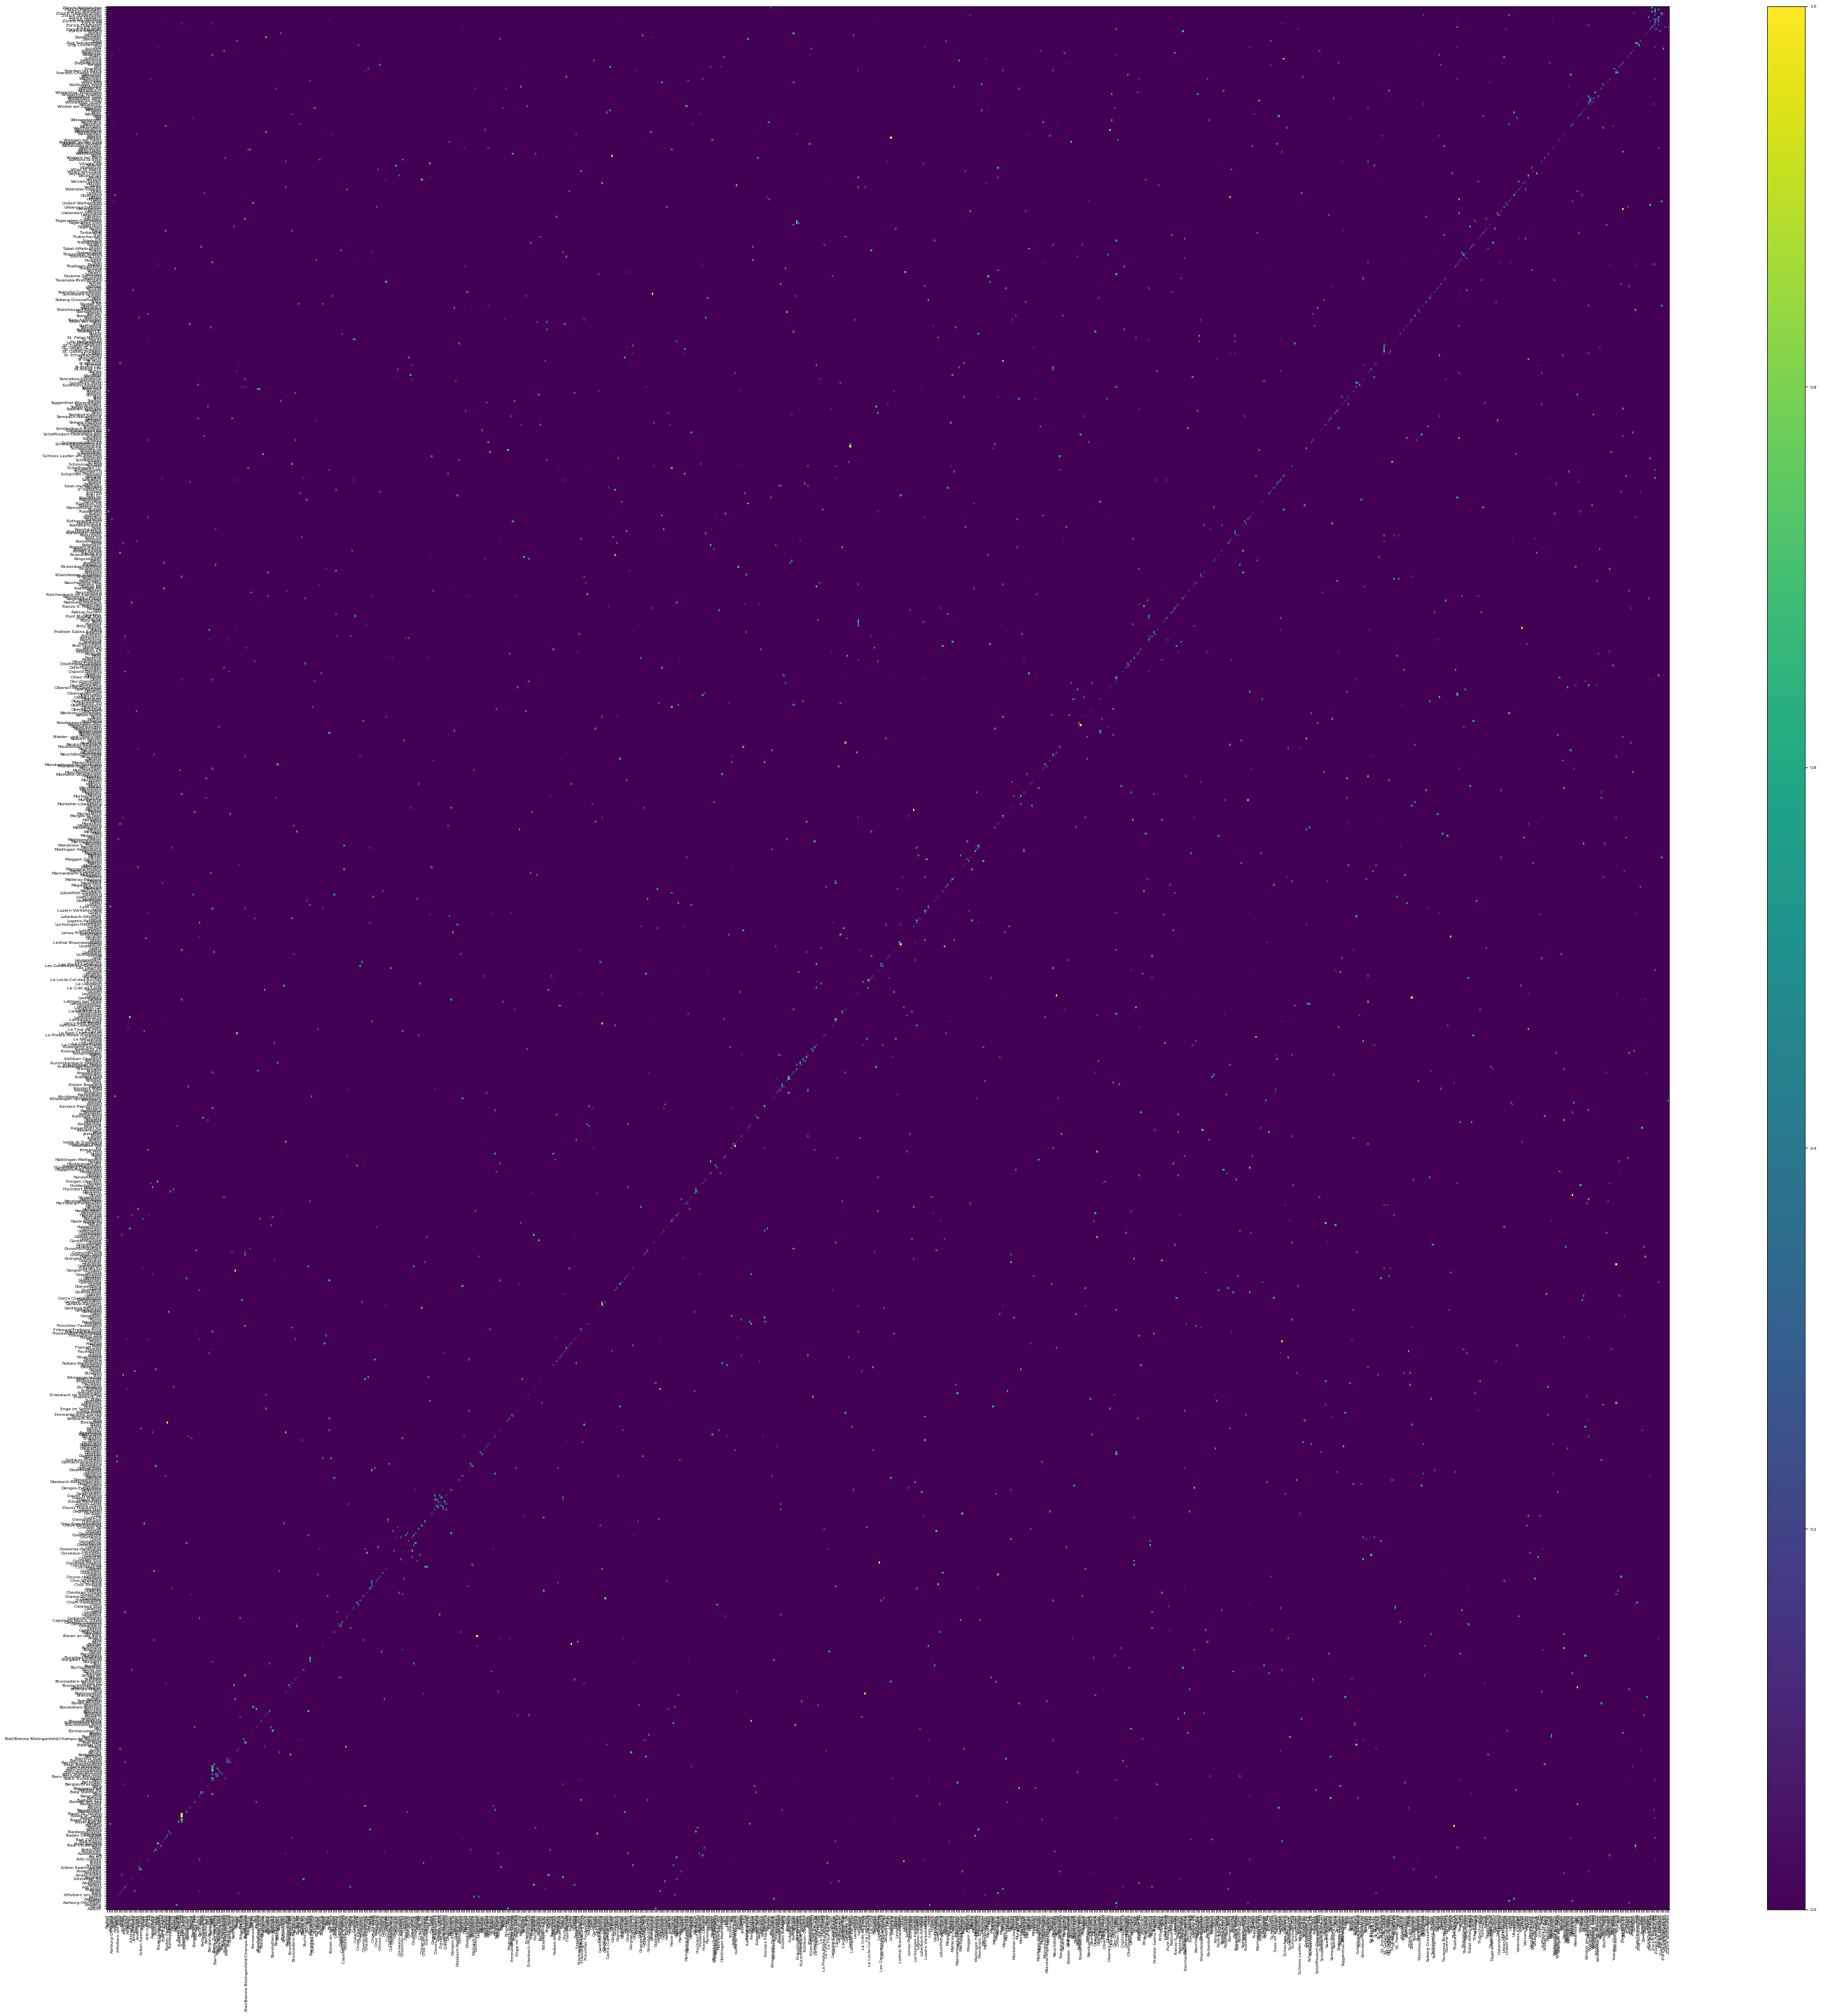

In [22]:
# Directed adjacency matrix
index = 0
TM = TMs[index]
font = {'size': 6}
plt.rc('font', **font)
plt.figure(figsize=(50, 50))
plt.pcolor(TM)
plt.yticks(np.arange(0.5, TM.shape[0], 1), TM.index)
plt.xticks(np.arange(0.5, TM.shape[0], 1), TM.columns, rotation='vertical')
plt.colorbar(aspect=50)
plt.show()
plt.close()

In [23]:
# Matrix size
sizes = []
for TM in TMs:
    s = TM.values.ravel()
    size = round(sum(s)).astype(int)
    sizes.append(size)

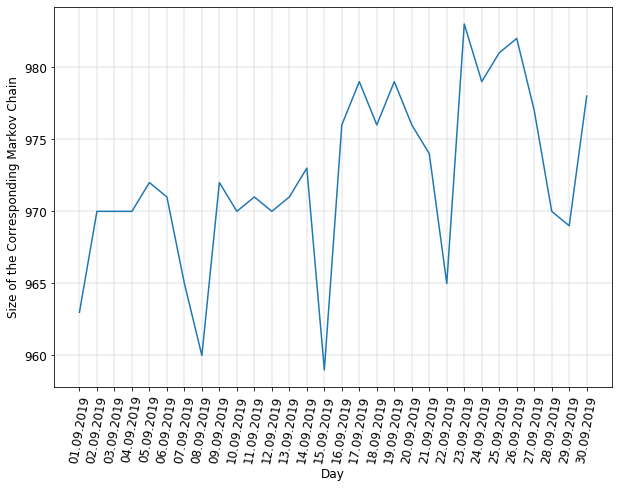

In [25]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

## Analysis

In [26]:
from scipy.linalg import norm
import time

In [27]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

### Using Power Iteration to calculate the steady state probabilities, Pi

In [28]:
Pi = []
Mixing_times = []

for TM in TMs:
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

Iterating 565 times in 0.8139715194702148
Iterating 763 times in 0.9669995307922363
Iterating 701 times in 0.8540029525756836
Iterating 731 times in 0.872004508972168
Iterating 631 times in 0.7880005836486816
Iterating 520 times in 0.6549997329711914
Iterating 658 times in 0.8050057888031006
Iterating 690 times in 0.8389987945556641
Iterating 652 times in 0.8029999732971191
Iterating 675 times in 0.7800147533416748
Iterating 1001 times in 1.260002851486206
Iterating 875 times in 1.024003505706787
Iterating 690 times in 0.9770002365112305
Iterating 595 times in 0.7300031185150146
Iterating 579 times in 0.7670040130615234
Iterating 597 times in 0.7730000019073486
Iterating 577 times in 0.7659990787506104
Iterating 750 times in 0.9010016918182373
Iterating 802 times in 0.9330039024353027
Iterating 633 times in 0.7160003185272217
Iterating 600 times in 0.7840056419372559
Iterating 652 times in 0.8830006122589111
Iterating 624 times in 0.7790031433105469
Iterating 583 times in 0.68600249290

### Average mixing time of Markov chains

In [29]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 15
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in trange(n):
    for j in range(len(TMs)):
        _, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

In [30]:
start = 0

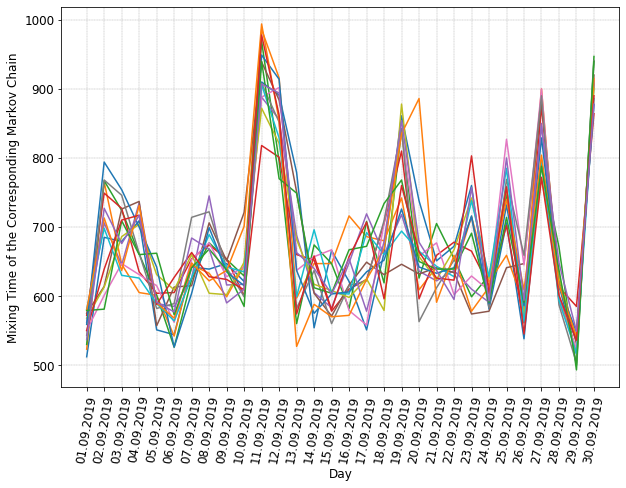

In [31]:
fig = plt.figure(figsize=(10, 7))
for mix in Mixing_times_n_times:
    plt.plot(mix[slice(start, None)])
font = {'size': 12}
plt.rc('font', **font)
plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

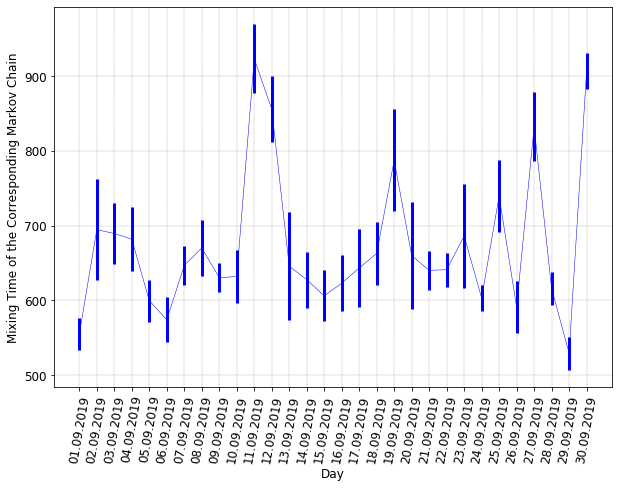

In [32]:
fig = plt.figure(figsize=(10, 7))
yerr = Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(len(TMs[slice(start, None)])),
    Mixing_times_n_times.mean(axis=0)[slice(start, None)],
    yerr=yerr[slice(start, None)],
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.5,
    elinewidth=3)
font = {'size': 12}
plt.rc('font', **font)

plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

In [33]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [34]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    #print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

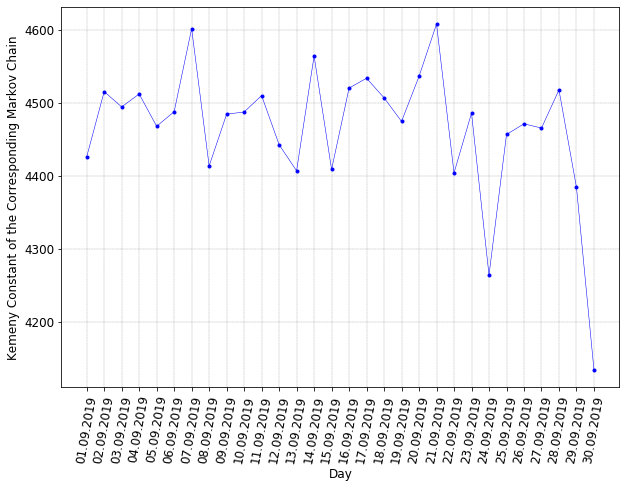

In [35]:
fig = plt.figure(figsize=(10, 7))
plt.plot(Kemenys[slice(start, None)], '.-b', linewidth=.51)

font = {'size': 12}
plt.rc('font', **font)

plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
xticks = [s for s in strings]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks[slice(start, None)],
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

In [36]:
# Steady distribution of stations
steady_states = []

for i, initial in enumerate(Vs):
    Steady_dist = initial
    Steady_dist['Pi'] = pi_list[i]
    # Trains stops - Percentage by Haltestelle
    freq = features[i]['HALTESTELLEN_NAME'].value_counts(normalize=True)
    freq = pd.DataFrame(freq).sort_index()
    freq = freq.rename(columns={'HALTESTELLEN_NAME': 'frequency'})
    Steady_dist['Freq'] = freq['frequency'].values
    Steady_dist['Date'] = str(datetime(year=2019, month=9, day=int(i + 1)))
    steady_states.append(Steady_dist)

In [37]:
# Plot it!
@interact
def plot(day=(start,len(steady_states)-1)):
    steady_states[day].plot.bar(x='Station', y=['Pi', 'Freq', 'Prob'], figsize=(50, 6), fontsize=5);

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

## Results

In [38]:
# Compute pagerank
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank[['Station', 'Pi', 'Freq', 'Prob', 'Date']]
    stationrank = stationrank.reset_index()
    stationrank = stationrank.drop(columns=['index'])
    stationranks.append(stationrank)

In [39]:
# Google it!
@interact
def rank(day=(start, len(steady_states) - 1)):
    return stationranks[day].head(25)

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [40]:
for df in steady_states:
    df.set_index('Station', inplace=True)

In [41]:
# Merge stations over whole month
merge = pd.concat(steady_states, axis=1, join='inner')
merge

,Prob,Pi,Freq,Date,Prob,Pi,Freq,Date,Prob,Pi,...,Freq,Date,Prob,Pi,Freq,Date,Prob,Pi,Freq,Date
Station,,,,,,,,,,,,,,,,,,,,,
Aadorf,0.000000,0.000364,0.000980,2019-09-01 00:00:00,0.000000,0.000435,0.000834,2019-09-02 00:00:00,0.000000,0.000406,...,0.000925,2019-09-28 00:00:00,0.000000,0.000300,0.001011,2019-09-29 00:00:00,0.000113,0.000208,0.000893,2019-09-30 00:00:00
Aarau,0.010012,0.008330,0.004392,2019-09-01 00:00:00,0.009381,0.007398,0.004182,2019-09-02 00:00:00,0.009365,0.007400,...,0.004212,2019-09-28 00:00:00,0.009844,0.007986,0.004353,2019-09-29 00:00:00,0.009386,0.006855,0.004196,2019-09-30 00:00:00
Aarberg,0.000000,0.000123,0.000438,2019-09-01 00:00:00,0.000000,0.000108,0.000401,2019-09-02 00:00:00,0.000000,0.000106,...,0.000414,2019-09-28 00:00:00,0.000000,0.000122,0.000422,2019-09-29 00:00:00,0.000000,0.000096,0.000390,2019-09-30 00:00:00
Aarburg-Oftringen,0.000000,0.000979,0.001407,2019-09-01 00:00:00,0.000000,0.000993,0.001500,2019-09-02 00:00:00,0.000000,0.000993,...,0.001317,2019-09-28 00:00:00,0.000000,0.000940,0.001377,2019-09-29 00:00:00,0.000000,0.000859,0.001477,2019-09-30 00:00:00
Aathal,0.000000,0.000656,0.000991,2019-09-01 00:00:00,0.000000,0.000532,0.000845,2019-09-02 00:00:00,0.000000,0.000492,...,0.000936,2019-09-28 00:00:00,0.000000,0.000560,0.000944,2019-09-29 00:00:00,0.000000,0.000388,0.000800,2019-09-30 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zürich Stadelhofen,0.000000,0.010263,0.008266,2019-09-01 00:00:00,0.000000,0.008797,0.007330,2019-09-02 00:00:00,0.000000,0.008511,...,0.007804,2019-09-28 00:00:00,0.000000,0.009068,0.007973,2019-09-29 00:00:00,0.000226,0.006701,0.007162,2019-09-30 00:00:00
Zürich Tiefenbrunnen,0.001284,0.001072,0.001948,2019-09-01 00:00:00,0.000686,0.000836,0.001626,2019-09-02 00:00:00,0.000685,0.000806,...,0.001829,2019-09-28 00:00:00,0.001246,0.000962,0.001899,2019-09-29 00:00:00,0.000452,0.000657,0.001601,2019-09-30 00:00:00
Zürich Wiedikon,0.000000,0.001191,0.002652,2019-09-01 00:00:00,0.000000,0.000998,0.002376,2019-09-02 00:00:00,0.000000,0.000985,...,0.002503,2019-09-28 00:00:00,0.000000,0.001089,0.002576,2019-09-29 00:00:00,0.000000,0.000860,0.002309,2019-09-30 00:00:00


In [42]:
indices = merge.index.values

## Share in Trains per Day (red) compared to structural power (blue) over time

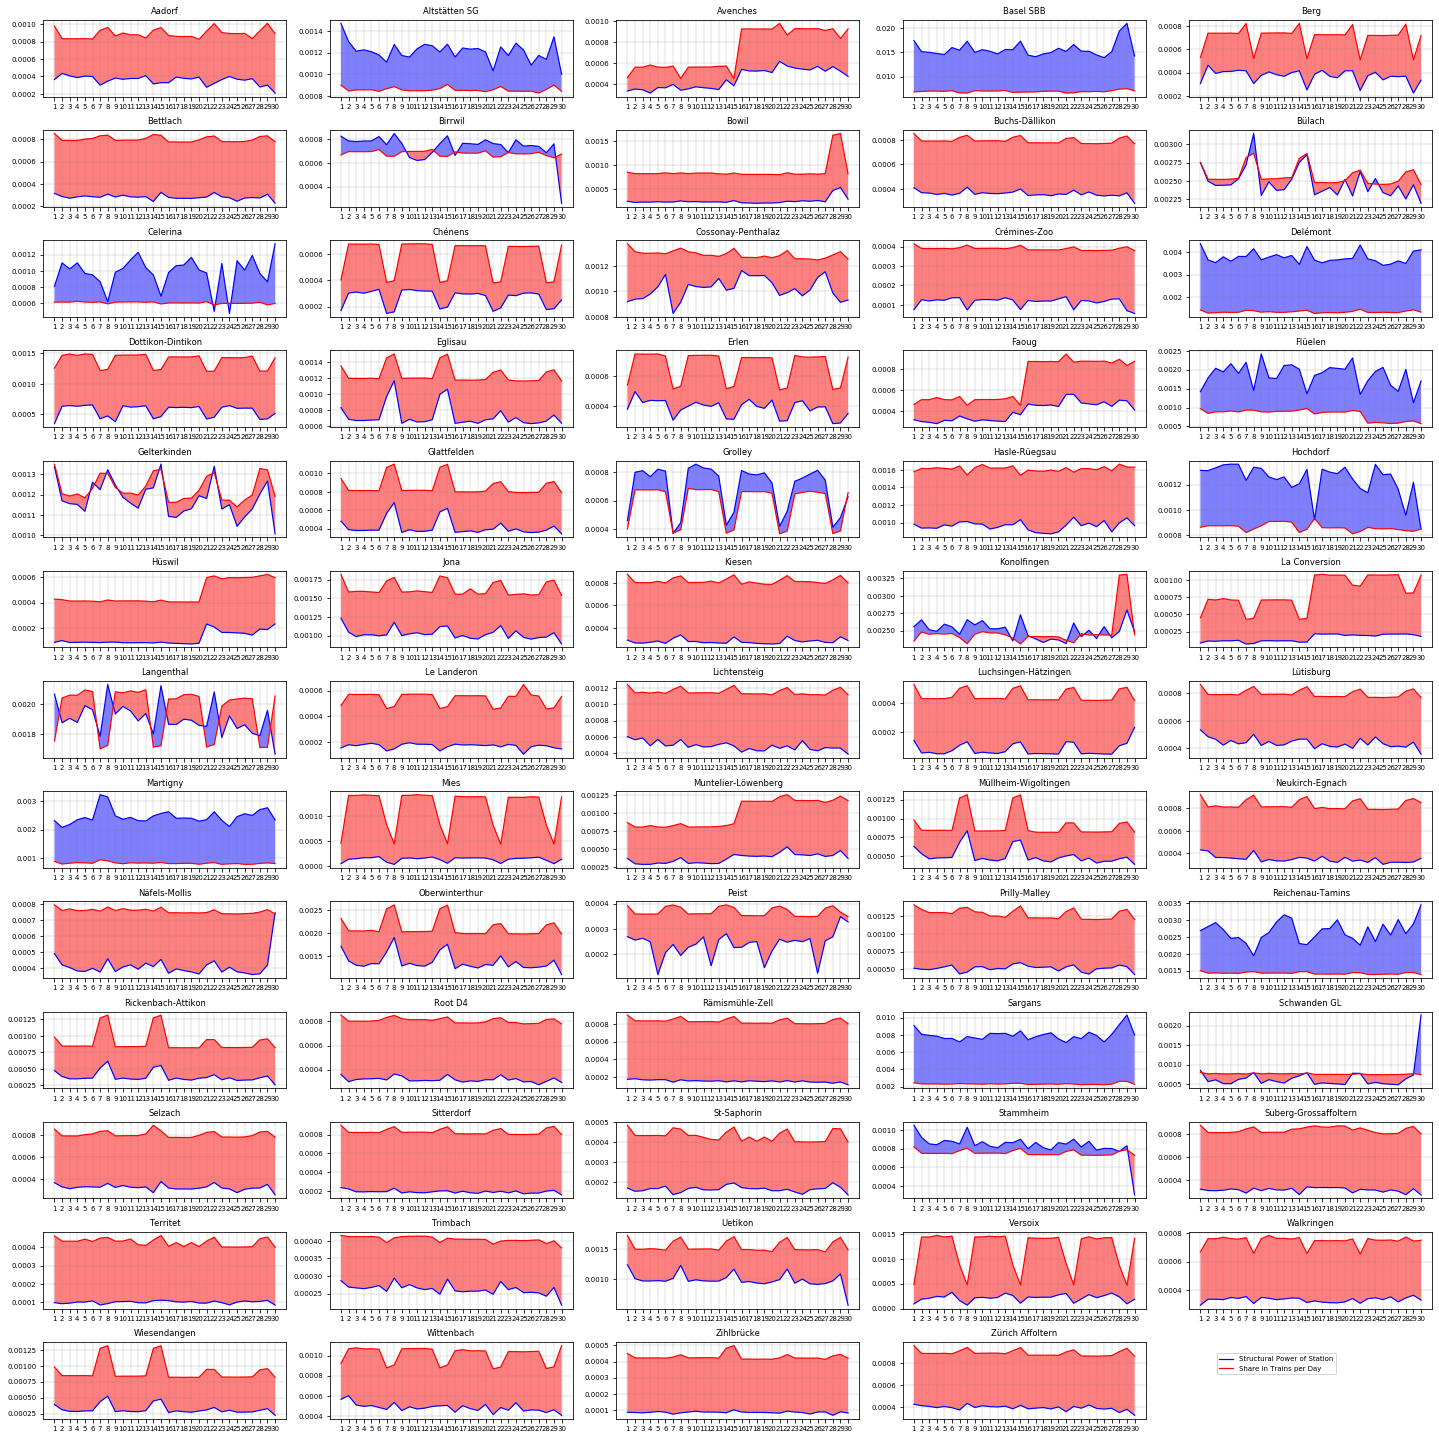

In [60]:
fig = plt.figure(figsize=(20, 20))
font = {'size': 7}
plt.rc('font', **font)

for j, i in enumerate(trange(0, len(indices), 15), 1):

    yPi = merge.loc[indices[i]][1::4].values
    yFreq = merge.loc[indices[i]][2::4].values

    plt.subplot(13, 5, j)
    plt.title(indices[i])

    plt.plot(
        range(len(steady_states)),
        yPi,
        '-b',
        linewidth=1.2,
        label='Structural Power of Station')
    plt.plot(
        range(len(steady_states)),
        yFreq,
        '-r',
        linewidth=1.2,
        label='Share in Trains per Day')
    
    y1 = yPi.astype(float)
    y2 = yFreq.astype(float)
    x = range(len(steady_states))

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)

    label = range(1, len(steady_states) + 1)
    plt.xticks(range(len(steady_states)), label)
    plt.tight_layout()
    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(1.8, 0.9))
plt.show()
plt.close()

## Sensitivity analysis of Markov chains

In [ ]:
# Sensitivity analysis on a single node
def change_node(M, i, percent=10):
    MC = M.copy()
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

## Network Visualization

In [44]:
import networkx as nx

In [45]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [9], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Date=str(pd.to_datetime(timestamp)[0]))
    attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Prepare for kepler.gl

In [46]:
import json

In [47]:
from networkx.readwrite import json_graph
from shapely.geometry import Point, LineString
from shapely_geojson import dump, dumps, Feature, FeatureCollection

In [48]:
node_features = []
edge_features = []

In [61]:
for index in trange(len(steady_states)):
    G = station_graph(index)
    graph = json_graph.node_link_data(G)
    for props in graph['nodes']:
        pos = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'id']].geopos.values[0]
        feature = Feature(Point(tuple(pos)), properties=props)
        node_features.append(feature)
    for props in graph['links']:
        source = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'source']].geopos.values[0]
        target = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'target']].geopos.values[0]
        feature = Feature(
            LineString([Point(tuple(source)),
                        Point(tuple(target))]), properties=props)
        edge_features.append(feature)

In [62]:
# Gather all features
graph_features = node_features + edge_features
feature_collection = FeatureCollection(graph_features)

In [63]:
# Write to file as geojson
with open('data/istdaten/September/graph.geojson', 'w') as outfile:
     dump(feature_collection, outfile, indent=2, ensure_ascii=False)
outfile.close()

### Interactive Plots

In [64]:
def plot_station_graph(index, size, geo=False, labels=False):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.6)
    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME']
                                                 == key].geopos.values[0])
        plt.figure(figsize=(50, 35))
        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.6)
    plt.show()

In [65]:
interact(plot_station_graph, index=(0,29), size=(4,6), geo ={True, False}, labels ={True, False});

interactive(children=(IntSlider(value=14, description='index', max=29), IntSlider(value=5, description='size',…

## Export the Graph

In [ ]:
# Write to file for further visualization
from networkx.drawing.nx_agraph import write_dot
import pygraphviz
index=0
write_dot(station_graph(index), 'data/mc.dot')

[See visualization here](https://nbviewer.jupyter.org/github/GAnagno/Social-Web/blob/master/data/markov/01092019.png)